# DermNet 皮肤病分类模型训练与测试 - Vision Transformer版本
基于Vision Transformer (ViT)的皮肤病图像分类模型训练和测试

## 1. 环境初始化和数据加载

In [1]:
import os
import json
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 设置matplotlib中文字体支持
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# 过滤字体警告
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# 导入ViT模型
from VIT import ViT_Base, ViT_Small

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 加载类别映射和权重
with open('processed_data/category_mapping.json', 'r', encoding='utf-8') as f:
    mapping_info = json.load(f)

with open('processed_data/class_weights.json', 'r') as f:
    class_weights_dict = json.load(f)

num_classes = mapping_info['num_classes']
print(f"类别数: {num_classes}")
print(f"类别: {mapping_info['categories'][:5]}...")  # 显示前5个类别

d:\Anaconda\envs\capstone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cuda
类别数: 23
类别: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections']...


## 2. 数据集定义

In [2]:
class DermNetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        print(f"数据集初始化完成，包含 {len(self.data)} 个样本")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if idx >= len(self.data):
            raise IndexError(f"索引 {idx} 超出范围 [0, {len(self.data)})]")
            
        row = self.data.iloc[idx]
        image_path = row['image_path']
        
        # 使用cv2.imdecode来处理中文路径
        try:
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"文件不存在: {image_path}")
                
            with open(image_path, 'rb') as f:
                image_data = f.read()
            
            if len(image_data) == 0:
                raise ValueError(f"文件为空: {image_path}")
                
            nparr = np.frombuffer(image_data, np.uint8)
            image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            
            if image is None:
                raise ValueError(f"无法解码图片: {image_path}")
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        except Exception as e:
            print(f"读取图片失败 {image_path}: {str(e)}")
            raise ValueError(f"无法读取图片 {image_path}: {str(e)}")
        
        # 应用数据变换
        if self.transform:
            try:
                transformed = self.transform(image=image)
                image = transformed['image']
            except Exception as e:
                print(f"数据变换失败: {str(e)}")
                raise ValueError(f"数据变换失败: {str(e)}")
        
        return image, row['label']

# 针对医学图像优化的数据增强策略
def get_transforms(mode='train'):
    if mode == 'train':
        return A.Compose([
            # 基础变换
            A.Resize(256, 256),
            A.RandomCrop(224, 224),
            
            # 医学图像适用的几何变换
            A.HorizontalFlip(p=0.5),  # 水平翻转（皮肤病图像通常左右对称性不重要）
            A.RandomRotate90(p=0.3),  # 90度旋转
            A.Rotate(limit=15, p=0.3),  # 小角度旋转
            
            # 颜色增强（医学图像需要谨慎）
            A.RandomBrightnessContrast(
                brightness_limit=0.15,  # 降低亮度变化范围
                contrast_limit=0.15,    # 降低对比度变化范围
                p=0.3
            ),
            A.HueSaturationValue(
                hue_shift_limit=10,     # 色调变化
                sat_shift_limit=15,     # 饱和度变化
                val_shift_limit=10,     # 明度变化
                p=0.2
            ),
            
            # 轻微的模糊和噪声（模拟不同的拍摄条件）
            A.OneOf([
                A.GaussianBlur(blur_limit=(1, 3), p=1.0),
                A.MotionBlur(blur_limit=3, p=1.0),
            ], p=0.15),
            
            # 轻微的噪声
            A.GaussNoise(var_limit=(5, 15), p=0.1),
            
            # 标准化（ImageNet预训练权重需要）
            A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])

## 3. 数据加载器创建

In [3]:
# 加载数据
train_df = pd.read_csv('processed_data/train.csv')
test_df = pd.read_csv('processed_data/test.csv')

print(f"训练集大小: {len(train_df)}")
print(f"测试集大小: {len(test_df)}")

# 先检查前几行数据的路径
print("\n前3行训练数据:")
print(train_df.head(3))

# 检查路径是否存在
print(f"\n检查前3个文件是否存在:")
for i in range(min(3, len(train_df))):
    path = train_df.iloc[i]['image_path']
    exists = os.path.exists(path)
    print(f"  {i+1}. {path} - {'存在' if exists else '不存在'}")

print("\n创建数据集...")
# 创建数据集
train_dataset = DermNetDataset(train_df, transform=get_transforms('train'))
test_dataset = DermNetDataset(test_df, transform=get_transforms('test'))

print("\n测试单个样本加载...")
try:
    sample_image, sample_label = train_dataset[0]
    print(f"单个样本测试成功: 图像形状 {sample_image.shape}, 标签 {sample_label}")
except Exception as e:
    print(f"单个样本测试失败: {str(e)}")
    import traceback
    traceback.print_exc()

# 只有单个样本成功后才创建数据加载器
print("\n创建数据加载器...")
batch_size = 16  # ViT通常使用较小的批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(f"训练批次数: {len(train_loader)}")
print(f"测试批次数: {len(test_loader)}")

训练集大小: 15557
测试集大小: 4002

前3行训练数据:
                                          image_path                 category  \
0  DermNet/train/Acne and Rosacea Photos/07Acne08...  Acne and Rosacea Photos   
1  DermNet/train/Acne and Rosacea Photos/07AcnePi...  Acne and Rosacea Photos   
2  DermNet/train/Acne and Rosacea Photos/07AcnePi...  Acne and Rosacea Photos   

  dataset_type  label  
0        train      0  
1        train      0  
2        train      0  

检查前3个文件是否存在:
  1. DermNet/train/Acne and Rosacea Photos/07Acne081101.jpg - 存在
  2. DermNet/train/Acne and Rosacea Photos/07AcnePittedScars.jpg - 存在
  3. DermNet/train/Acne and Rosacea Photos/07AcnePittedScars1.jpg - 存在

创建数据集...
数据集初始化完成，包含 15557 个样本
数据集初始化完成，包含 4002 个样本

测试单个样本加载...
单个样本测试成功: 图像形状 torch.Size([3, 224, 224]), 标签 0

创建数据加载器...
训练批次数: 973
测试批次数: 251


C:\Users\XYD\AppData\Local\Temp\ipykernel_33648\211012168.py:84: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 15), p=0.1),


## 4. ViT模型初始化

In [4]:
# 重新导入ViT模块以确保使用最新版本
import importlib
import timm

# 使用timm加载预训练的ViT模型
use_pretrained = True  # 使用预训练权重
model_name = 'vit_base_patch16_224'  # ViT-Base/16 224x224

print(f"正在加载预训练ViT模型: {model_name}")

if use_pretrained:
    # 使用timm加载预训练模型
    model = timm.create_model(
        model_name,
        pretrained=True,  # 加载ImageNet预训练权重
        num_classes=num_classes,  # 修改分类头为皮肤病类别数
        drop_rate=0.1,  # dropout率
        drop_path_rate=0.1  # DropPath率（随机深度）
    )
    print(f"✓ 成功加载预训练ViT模型: {model_name}")
else:
    # 随机初始化
    model = timm.create_model(
        model_name,
        pretrained=False,
        num_classes=num_classes,
        drop_rate=0.1
    )
    print("使用随机初始化权重")

# 将模型移到设备上
model = model.to(device)

# 可选：冻结部分层进行微调
freeze_backbone = False  # 是否冻结backbone

if freeze_backbone and use_pretrained:
    # 冻结除了分类头之外的所有参数
    for name, param in model.named_parameters():
        if 'head' not in name:  # timm中分类层通常叫'head'
            param.requires_grad = False
    print("✓ 已冻结backbone，仅训练分类头")

print("ViT模型创建成功")

# 损失函数（使用类别权重）
class_weights = torch.tensor([class_weights_dict[str(i)] for i in range(num_classes)], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 优化器 - ViT通常需要更小的学习率
if freeze_backbone:
    learning_rate = 0.001  # 仅训练分类头时可以用较大学习率
else:
    learning_rate = 0.0001 if use_pretrained else 0.001  # 全模型微调用较小学习率

optimizer = optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=0.05,  # ViT通常用较大的weight decay
    betas=(0.9, 0.999)
)

# 学习率调度器
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("模型初始化完成")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"可训练参数量: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"学习率: {learning_rate}")
print(f"使用预训练权重: {'是' if use_pretrained else '否'}")
print(f"冻结backbone: {'是' if freeze_backbone else '否'}")
print(f"类别权重范围: {class_weights.min():.3f} ~ {class_weights.max():.3f}")

# 显示模型架构概要
print("\n模型架构概要:")
from torchsummary import summary
summary(model, (3, 224, 224))

正在加载预训练ViT模型: vit_base_patch16_224
✓ 成功加载预训练ViT模型: vit_base_patch16_224
✓ 成功加载预训练ViT模型: vit_base_patch16_224
ViT模型创建成功
模型初始化完成
模型参数量: 85,816,343
可训练参数量: 85,816,343
学习率: 0.0001
使用预训练权重: 是
冻结backbone: 否
类别权重范围: 0.484 ~ 3.209

模型架构概要:
ViT模型创建成功
模型初始化完成
模型参数量: 85,816,343
可训练参数量: 85,816,343
学习率: 0.0001
使用预训练权重: 是
冻结backbone: 否
类别权重范围: 0.484 ~ 3.209

模型架构概要:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
    

## 5. 训练函数

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='训练中')
    for batch_idx, (images, labels) in enumerate(pbar, 1):  # 添加batch_idx计数
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # 梯度裁剪（对ViT很重要）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 更新进度条 - 使用batch_idx而不是len(pbar)
        pbar.set_postfix({
            'Loss': f'{running_loss/batch_idx:.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='验证中')
        for batch_idx, (images, labels) in enumerate(pbar, 1):  # 添加batch_idx计数
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # 更新进度条 - 使用batch_idx而不是len(pbar)
            pbar.set_postfix({
                'Loss': f'{running_loss/batch_idx:.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

## 6. 模型训练

In [ ]:
# 训练设置
num_epochs = 300
best_val_loss = float('inf')
best_val_acc = 0.0
patience = 20
patience_counter = 0

# 创建保存目录
os.makedirs('models', exist_ok=True)

# 训练历史记录
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("开始训练ViT模型...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # 训练
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 验证（使用测试集作为验证集）
    val_loss, val_acc, _, _ = validate_epoch(model, test_loader, criterion, device)
    
    # 学习率调度
    scheduler.step(val_loss)
    
    # 记录历史
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        # 保存最佳模型
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'mapping_info': mapping_info
        }, 'models/best_model_vit.pth')
        
        print(f"✓ 保存最佳ViT模型 (验证损失: {best_val_loss:.4f}, 验证准确率: {best_val_acc:.2f}%)")
    else:
        patience_counter += 1
        
    # 早停
    if patience_counter >= patience:
        print(f"早停触发，连续{patience}个epoch验证损失没有改善")
        break

print(f"\nViT训练完成！最佳验证准确率: {best_val_acc:.2f}%")

开始训练ViT模型...

Epoch 1/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:29<00:00,  8.57it/s, Loss=2.5207, Acc=26.41%]



✓ 保存最佳ViT模型 (验证损失: 2.5207, 验证准确率: 26.41%)

Epoch 2/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:28<00:00,  8.93it/s, Loss=2.5412, Acc=25.09%]



Epoch 3/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.01it/s, Loss=2.1406, Acc=36.26%]



✓ 保存最佳ViT模型 (验证损失: 2.1406, 验证准确率: 36.26%)

Epoch 4/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  8.99it/s, Loss=2.1056, Acc=36.73%]



✓ 保存最佳ViT模型 (验证损失: 2.1056, 验证准确率: 36.73%)

Epoch 5/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.03it/s, Loss=2.1507, Acc=36.41%]



Epoch 6/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  8.97it/s, Loss=1.8912, Acc=42.58%]



✓ 保存最佳ViT模型 (验证损失: 1.8912, 验证准确率: 42.58%)

Epoch 7/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.03it/s, Loss=1.8621, Acc=44.08%]



✓ 保存最佳ViT模型 (验证损失: 1.8621, 验证准确率: 44.08%)

Epoch 8/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.02it/s, Loss=1.8438, Acc=44.73%]



✓ 保存最佳ViT模型 (验证损失: 1.8438, 验证准确率: 44.73%)

Epoch 9/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  8.99it/s, Loss=1.7916, Acc=46.35%]



✓ 保存最佳ViT模型 (验证损失: 1.7916, 验证准确率: 46.35%)

Epoch 10/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.01it/s, Loss=1.7030, Acc=50.70%]



✓ 保存最佳ViT模型 (验证损失: 1.7030, 验证准确率: 50.70%)

Epoch 11/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.03it/s, Loss=1.6676, Acc=51.80%]



✓ 保存最佳ViT模型 (验证损失: 1.6676, 验证准确率: 51.80%)

Epoch 12/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  8.97it/s, Loss=1.6611, Acc=51.35%]



✓ 保存最佳ViT模型 (验证损失: 1.6611, 验证准确率: 51.35%)

Epoch 13/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.00it/s, Loss=1.6781, Acc=52.77%]



Epoch 14/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.02it/s, Loss=1.7219, Acc=53.75%]



Epoch 15/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.01it/s, Loss=1.6106, Acc=56.37%]



✓ 保存最佳ViT模型 (验证损失: 1.6106, 验证准确率: 56.37%)

Epoch 16/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.01it/s, Loss=1.6123, Acc=56.07%]



Epoch 17/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.02it/s, Loss=1.5822, Acc=57.37%]



✓ 保存最佳ViT模型 (验证损失: 1.5822, 验证准确率: 57.37%)

Epoch 18/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.01it/s, Loss=1.6774, Acc=56.00%]



Epoch 19/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.01it/s, Loss=1.7029, Acc=56.87%]



Epoch 20/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.01it/s, Loss=1.5906, Acc=58.82%]



Epoch 21/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.02it/s, Loss=1.6413, Acc=59.97%]



Epoch 22/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  8.98it/s, Loss=1.6853, Acc=63.52%]



Epoch 23/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  8.99it/s, Loss=1.7297, Acc=63.54%]



Epoch 24/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:27<00:00,  9.01it/s, Loss=1.7006, Acc=63.77%]



Epoch 25/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:31<00:00,  8.08it/s, Loss=1.7435, Acc=63.97%]



Epoch 26/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:29<00:00,  8.52it/s, Loss=1.7843, Acc=66.52%]



Epoch 27/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:31<00:00,  8.05it/s, Loss=1.8459, Acc=67.07%]



Epoch 28/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:30<00:00,  8.13it/s, Loss=1.9925, Acc=66.52%]



Epoch 29/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:30<00:00,  8.17it/s, Loss=1.8604, Acc=66.47%]



Epoch 30/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:30<00:00,  8.15it/s, Loss=1.9019, Acc=68.12%]



Epoch 31/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s, Loss=1.9541, Acc=68.17%]



Epoch 32/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:30<00:00,  8.19it/s, Loss=1.9581, Acc=68.54%]



Epoch 33/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:30<00:00,  8.16it/s, Loss=1.9652, Acc=68.74%]



Epoch 34/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:30<00:00,  8.15it/s, Loss=1.9660, Acc=68.87%]



Epoch 35/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:30<00:00,  8.21it/s, Loss=2.0068, Acc=68.87%]



Epoch 36/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:31<00:00,  8.05it/s, Loss=2.0146, Acc=68.99%]



Epoch 37/300
--------------------------------------------------


验证中: 100%|██████████| 251/251 [00:31<00:00,  8.07it/s, Loss=2.0062, Acc=68.82%]

早停触发，连续20个epoch验证损失没有改善

ViT训练完成！最佳验证准确率: 57.37%


In [1]:
torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'mapping_info': mapping_info
        }, 'models/last_model_vit.pth')

NameError: name 'torch' is not defined

## 7. 训练历史可视化

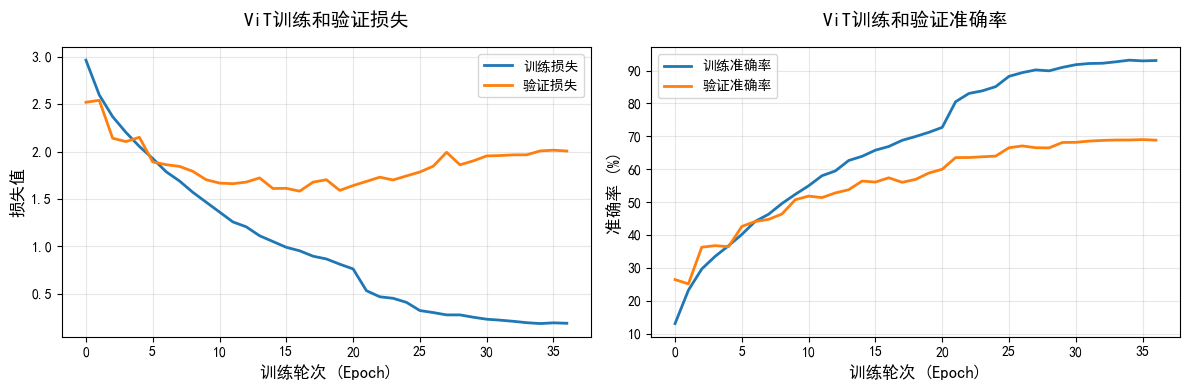

ViT训练历史图表已保存


In [7]:
# 绘制训练历史
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失', linewidth=2)
plt.plot(val_losses, label='验证损失', linewidth=2)
plt.title('ViT训练和验证损失', fontsize=14, pad=15)
plt.xlabel('训练轮次 (Epoch)', fontsize=12)
plt.ylabel('损失值', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='训练准确率', linewidth=2)
plt.plot(val_accs, label='验证准确率', linewidth=2)
plt.title('ViT训练和验证准确率', fontsize=14, pad=15)
plt.xlabel('训练轮次 (Epoch)', fontsize=12)
plt.ylabel('准确率 (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/training_history_vit.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("ViT训练历史图表已保存")

## 8. 模型测试

In [8]:
# 加载最佳模型
checkpoint = torch.load('models/best_model_vit.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"加载最佳ViT模型 (Epoch {checkpoint['epoch']})")
print(f"最佳验证损失: {checkpoint['best_val_loss']:.4f}")
print(f"最佳验证准确率: {checkpoint['best_val_acc']:.2f}%")

# 在测试集上评估
print("\n在测试集上评估ViT模型...")
test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)

print(f"\nViT测试结果:")
print(f"测试损失: {test_loss:.4f}")
print(f"测试准确率: {test_acc:.2f}%")

加载最佳ViT模型 (Epoch 17)
最佳验证损失: 1.5822
最佳验证准确率: 57.37%

在测试集上评估ViT模型...


验证中: 100%|██████████| 251/251 [00:31<00:00,  7.91it/s, Loss=1.5822, Acc=57.37%]


ViT测试结果:
测试损失: 1.5822
测试准确率: 57.37%


## 9. 详细评估和可视化


ViT分类报告:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos      0.841     0.795     0.817       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions      0.674     0.531     0.594       288
                                          Atopic Dermatitis Photos      0.383     0.569     0.458       123
                                            Bullous Disease Photos      0.433     0.487     0.458       113
                Cellulitis Impetigo and other Bacterial Infections      0.306     0.507     0.381        73
                                                     Eczema Photos      0.640     0.466     0.539       309
                                      Exanthems and Drug Eruptions      0.635     0.396     0.488       101
                 Hair Loss Photos Alopecia and other Hair Diseases      0.406     0.900     0.560        60
                 

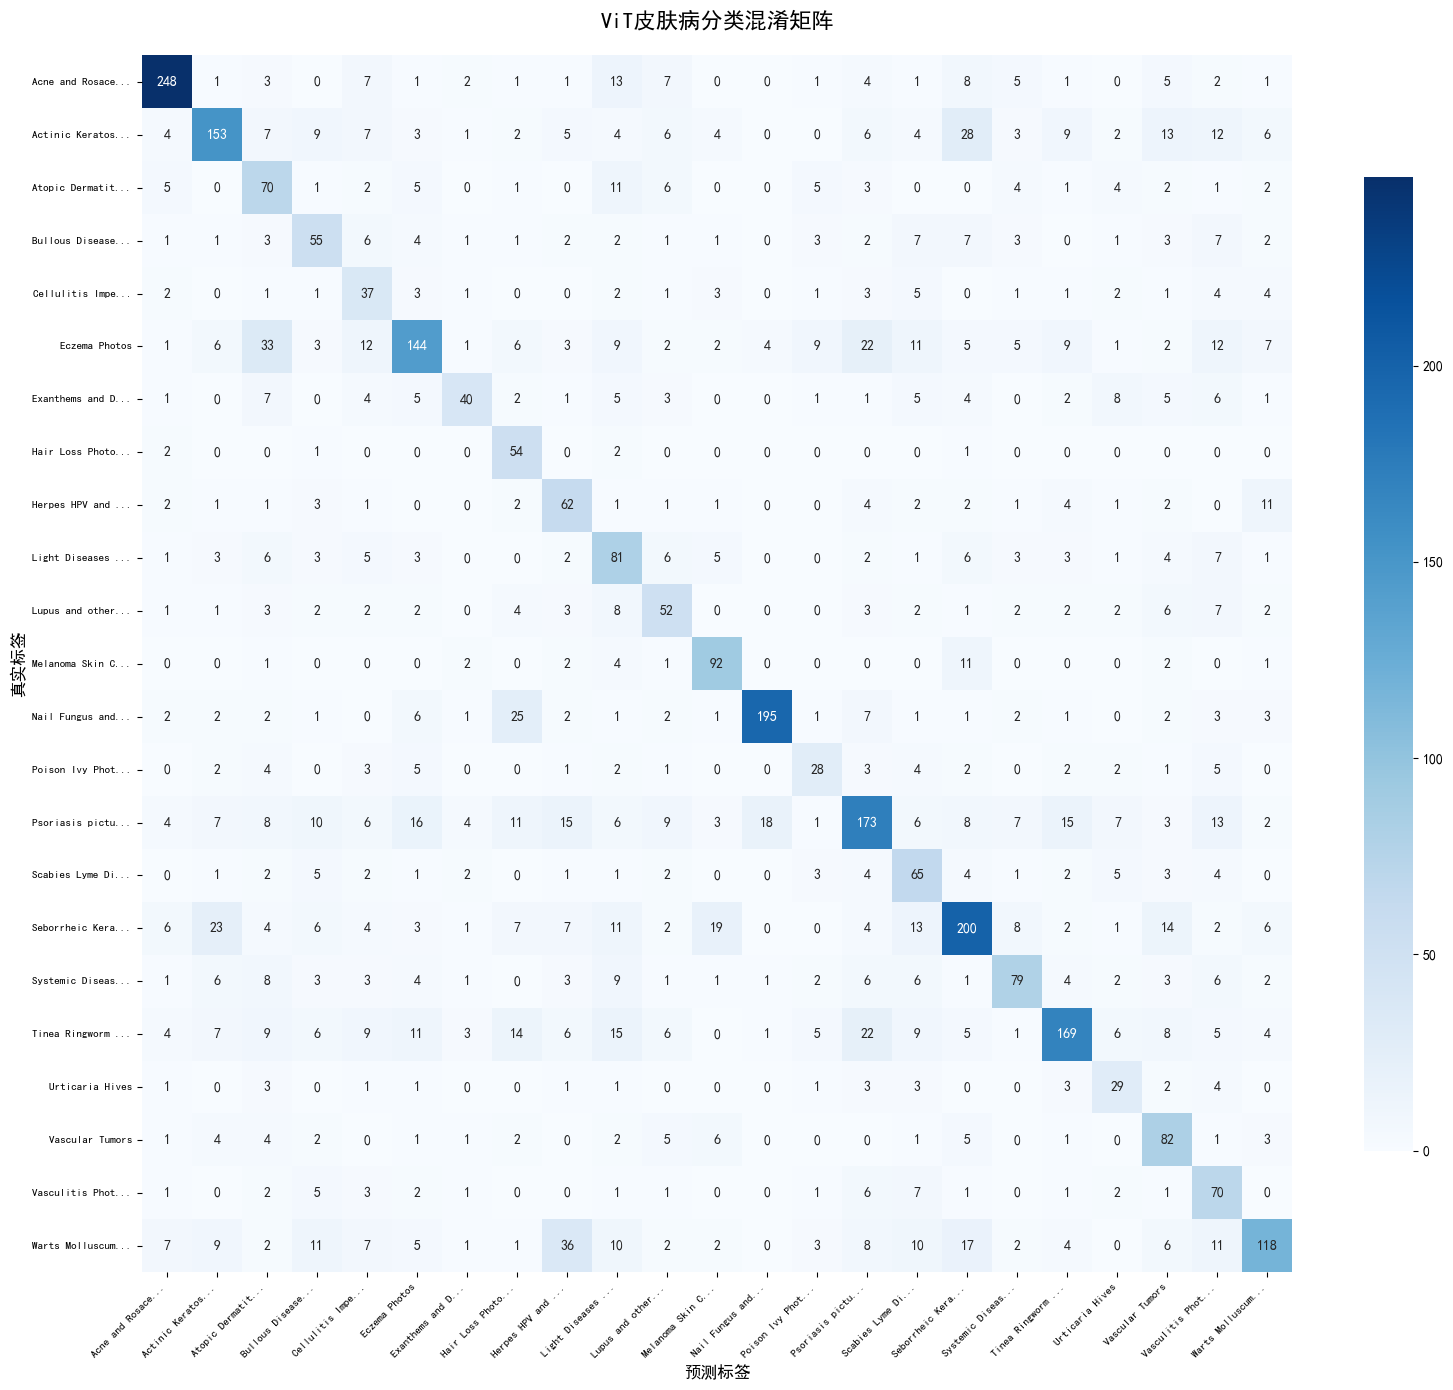


ViT混淆矩阵已保存


In [9]:
# 分类报告
print("\nViT分类报告:")
print(classification_report(test_labels, test_preds, 
                          target_names=mapping_info['categories'], 
                          digits=3))

# 混淆矩阵
cm = confusion_matrix(test_labels, test_preds)

# 简化类别名称以便显示
short_categories = []
for cat in mapping_info['categories']:
    if len(cat) > 15:  # 如果类别名太长，截取前15个字符
        short_cat = cat[:15] + "..."
    else:
        short_cat = cat
    short_categories.append(short_cat)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=short_categories,
            yticklabels=short_categories,
            cbar_kws={'shrink': 0.8})

plt.title('ViT皮肤病分类混淆矩阵', fontsize=16, pad=20)
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)

# 调整标签
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig('models/confusion_matrix_vit.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("\nViT混淆矩阵已保存")

## 10. 保存最终结果

In [10]:
# 保存训练历史
history = {
    'model_type': 'Vision Transformer',
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'best_val_loss': best_val_loss,
    'best_val_acc': best_val_acc,
    'test_loss': test_loss,
    'test_acc': test_acc
}

with open('models/training_history_vit.json', 'w') as f:
    json.dump(history, f, indent=2)

# 保存测试结果
test_results = {
    'model_type': 'Vision Transformer',
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'classification_report': classification_report(test_labels, test_preds, 
                                                 target_names=mapping_info['categories'], 
                                                 output_dict=True)
}

with open('models/test_results_vit.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print("\n=== ViT训练和测试完成 ===")
print(f"最佳模型保存在: models/best_model_vit.pth")
print(f"训练历史保存在: models/training_history_vit.json")
print(f"测试结果保存在: models/test_results_vit.json")
print(f"\nViT最终测试准确率: {test_acc:.2f}%")


=== ViT训练和测试完成 ===
最佳模型保存在: models/best_model_vit.pth
训练历史保存在: models/training_history_vit.json
测试结果保存在: models/test_results_vit.json

ViT最终测试准确率: 57.37%
